In [1]:
import pandas as pd
data = pd.read_csv("erdVH2018r6718day_30ba_fcc0_001f.csv")
data.head()

/tmp/ipykernel_420/3945954512.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("erdVH2018r6718day_30ba_fcc0_001f.csv")


,time,latitude,longitude,r671
0,UTC,degrees_north,degrees_east,sr^-1
1,2018-07-16T00:00:00Z,89.979164,-179.97917,NaN
2,2018-07-16T00:00:00Z,89.979164,-179.5625,NaN
3,2018-07-16T00:00:00Z,89.979164,-179.14583,NaN
4,2018-07-16T00:00:00Z,89.979164,-178.72917,NaN


In [2]:
data.isna().sum()

time               0
latitude           0
longitude          0
r671         1351462
dtype: int64

In [3]:
data = data[data['r671'].notna()]
data.head()

,time,latitude,longitude,r671
0,UTC,degrees_north,degrees_east,sr^-1
14977,2018-07-16T00:00:00Z,82.895836,-59.979164,4.3E-4
14978,2018-07-16T00:00:00Z,82.895836,-59.562496,4.2E-4
14979,2018-07-16T00:00:00Z,82.895836,-59.14583,3.94E-4
14980,2018-07-16T00:00:00Z,82.895836,-58.729164,4.16E-4


In [4]:
data.shape

(514779, 4)

In [6]:
data.drop(data.index[0], inplace=True)
data

,time,latitude,longitude,r671
14977,2018-07-16T00:00:00Z,82.895836,-59.979164,4.3E-4
14978,2018-07-16T00:00:00Z,82.895836,-59.562496,4.2E-4
14979,2018-07-16T00:00:00Z,82.895836,-59.14583,3.94E-4
14980,2018-07-16T00:00:00Z,82.895836,-58.729164,4.16E-4
14981,2018-07-16T00:00:00Z,82.895836,-58.312496,4.26E-4
...,...,...,...,...
1805212,2020-04-10T00:00:00Z,-60.437504,-48.729164,0.000114
1805214,2020-04-10T00:00:00Z,-60.437504,-47.89583,0.000136
1805215,2020-04-10T00:00:00Z,-60.437504,-47.479164,0.000146
1805216,2020-04-10T00:00:00Z,-60.437504,-47.062496,0.000162


In [11]:
data.columns

Index(['time', 'latitude', 'longitude', 'r671'], dtype='object')

In [16]:
# Convert 'latitude' column to numeric
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data.dropna(subset=['latitude'], inplace=True)

# Convert 'longitude' column to numeric
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
data.dropna(subset=['longitude'], inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

# Define grid size
grid_size = 1  # in degrees

# Create grid
min_lat, max_lat = data['latitude'].min(), data['latitude'].max()
min_lon, max_lon = data['longitude'].min(), data['longitude'].max()
lats = np.arange(min_lat, max_lat + grid_size, grid_size)
lons = np.arange(min_lon, max_lon + grid_size, grid_size)

# Calculate mean chlorophyll content for each grid cell
mean_chlorophyll = []
for lat in lats:
    for lon in lons:
        lat_mask = (data['latitude'] >= lat) & (data['latitude'] < lat + grid_size)
        lon_mask = (data['longitude'] >= lon) & (data['longitude'] < lon + grid_size)
        cell_data = data[lat_mask & lon_mask]
        if not cell_data.empty:
            mean_chlorophyll.append(cell_data['r671'].mean())
        else:
            mean_chlorophyll.append(np.nan)

# Reshape mean chlorophyll content to match the grid
mean_chlorophyll = np.array(mean_chlorophyll).reshape(len(lats), len(lons))

# Create a new figure
plt.figure(figsize=(12, 8))

# Define the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot mean chlorophyll content using a heatmap
im = ax.imshow(mean_chlorophyll, extent=(min_lon, max_lon, min_lat, max_lat), origin='lower',
               cmap='viridis', aspect='auto', transform=ccrs.PlateCarree())

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Mean Chlorophyll Content')

# Set the title
plt.title('Geological Map Visualizing Mean Chlorophyll Content')

# Show the plot
plt.show()


In [ ]:
# Import libraries (assuming you have GDAL installed)
from subprocess import call

# Define file paths (replace with your actual file names)
nc_file = "chlorophyll_a1.nc"
tif_file = "chlorophyll_a1.tif"

# GDAL command for conversion
gdal_command = ["gdal_translate", "-of", "GTIFF", nc_file, tif_file]

# Execute GDAL command using subprocess.call
call(gdal_command)

print(f"Converted {nc_file} to {tif_file} (GeoTIFF) using GDAL.")


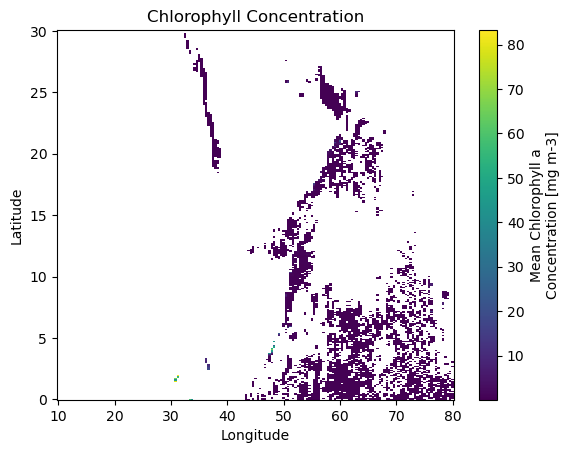

In [27]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the NetCDF file
data = xr.open_dataset("chlorophyll_a1.nc")

# Extract chlorophyll concentration data
chlorophyll = data['chlorophyll']

# Plot the data
chlorophyll.plot()

# Add title and labels
plt.title('Chlorophyll Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [31]:
import geopandas as gpd
from shapely.geometry import Polygon

# Define the coordinates of the bounding box
min_lon, max_lon = 10, 80
min_lat, max_lat = 0, 30

# Create a Polygon representing the bounding box
polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat),
                   (max_lon, max_lat), (max_lon, min_lat)])

# Create a GeoDataFrame with the bounding box Polygon
gdf = gpd.GeoDataFrame({'geometry': [polygon]})


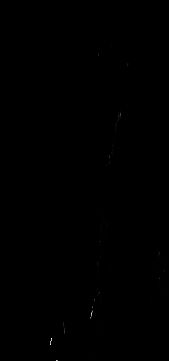

In [43]:
import folium
import rasterio
import numpy as np

# Load the chlorophyll data
with rasterio.open('chlorophyll_a1.tif') as src:
    chlorophyll_data = src.read(1, masked=True)
    extent = src.bounds

# Replace NaN values with zero
chlorophyll_data_filled = np.nan_to_num(chlorophyll_data, nan=0)

# Define the center of the map
center_lat = (extent.bottom + extent.top) / 2
center_lon = (extent.left + extent.right) / 2

# Create a Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add the chlorophyll data as a heatmap layer
folium.raster_layers.ImageOverlay(
    image=chlorophyll_data_filled,
    bounds=[[extent.bottom, extent.left], [extent.top, extent.right]],
    colormap='YlGnBu',
    mercator_project=True
).add_to(m)

# Display the map
m
